# Scikit-rt plotting demo

This notebook demonstrates some scikit-rt plotting capabilities, using the dataset:

Peihan Li, "SPECT_CT_data.zip", Figshare dataset (2020)<br/>
https://doi.org/10.6084/m9.figshare.12579707.v1

**Note:** If not alread present on the computer where this notebook is run, the dataset will be downloaded to the directory specified by `topdir` in the
first code cell below.  The download file has a size of 1.6 GB, so download may
take a while.

## Module import and data download

The following imports modules needed for this demo, defines the path
to the data directory, and downloads the demo dataset if not already present.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from skrt import Patient
from skrt.core import download
from skrt.dose import sum_doses

# Define URL of source dataset, and local data directory.
url = "https://figshare.com/ndownloader/files/23528954/SPECT_CT_data.zip"
topdir = Path("~/data/spect_ct").expanduser()
datadir = topdir / Path(url).stem

# Download dataset if not already present.
if not datadir.exists():
    download(url, topdir, unzip=True)

## Matplotlib configuration

Scikit-rt uses [matplotlib](https://matplotlib.org/) for data visualisation.  The following demonstrates how [matplotlib](https://matplotlib.org/) configuration
settings may be altered, to change the way in which images are displayed.

In [2]:
# Set Matplotlib runtime configuration.
# For details of Matplotlib configuration, see:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
# Sizes are in points.

# For axes, set spacing (pad) and size of label and title
plt.rc("axes", labelpad=0, labelsize=25, titlepad=17, titlesize=25)

# Set default text charactieristics.
# Possible weight values are:
# 100, 200, 300, 400 / "normal", 500, 600, 700 / "bold", 800, 900.
plt.rc("font", family="serif", serif=["Times"], size=20, weight=400)

# Set mathematics typeface when using matplotlib's built-in fonts.
plt.rc("mathtext", fontset="dejavuserif")

# Use TeX/LaTeX for typesetting.  (This requires working TeX/LaTeX installation.)
plt.rc("text", usetex=False)

# Set fontsize for legend labels.
plt.rc("legend", fontsize=17)

# For ticks, set label size and direction ("in", "out", "inout").
plt.rc(("xtick", "ytick"), labelsize=25, direction="out")

# For major and minor ticks, set size and width.
# For major ticks, set spacing (pad) of label.
plt.rc(("xtick.major"), pad=3)
plt.rc(("xtick.major", "ytick.major"), size=9, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0)
plt.rc(("ytick.major"), pad=2)

## Scikit-rt plotting options

The scikit-rt class providing for object display is [BetterViewer](https://scikit-rt.github.io/scikit-rt/skrt.better_viewer.html#skrt.better_viewer.BetterViewer), which
accepts a large number of plotting options.  The following demonstrates creation
of a dictionary of [BetterViewer](https://scikit-rt.github.io/scikit-rt/skrt.better_viewer.html#skrt.better_viewer.BetterViewer) keyword arguments.

In [3]:
# Create dictionary of default plotting options.
kwargs = {
    # Make plots interactive ("no_ui": False) or non-interactive ("no_ui": True).
    "no_ui": False,
    # Set figure size in inches.
    "figsize": (10, 6),
    # Show major ticks at specified interval (axis units).
    "major_ticks": 60,
    # Show minor ticks for specified number of intervals between major ticks.
    "minor_ticks": 5,
    # Indicate whether axis units should be mm or numbers of voxels.
    "scale_in_mm" : True,
    # Indicate whether ticks should be shown on all sides.
    "ticks_all_sides": True,
    # Specify zoom factor.
    "zoom": 2.0,
}

# Set fontsize for annotations.
# Value set via plt.rc("font", size=20) seems not to be applied consistently.
annotation_fontsize = 20

## Reading of patient data

The following demonstrates creation of a sorted list of paths to patient folders, reading of the data for a single [Patient](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Patient), and identification of the [Study](https://scikit-rt.github.io/scikit-rt/skrt.patient.html#skrt.patient.Study) containing data of interest here: CT image, structure set, dose from radiotherapy planning.

In [4]:
# Obtain sorted list of paths to patient folders.
paths = sorted(list(datadir.glob("0*")))

# Define index for path to patient folder of interest.
idx = 0

# Read patient data.
patient = Patient(paths[idx], unsorted_dicom=True)

# Identify study containing ct_image, ct_structure_set, ct_dose.
# If no study contains all of these data types,
# an exception will be raised.
for study in patient.studies + [None]:
    if all(["ct" in getattr(study, f"{dtype}_types", [])
            for dtype in ["image", "structure_set", "dose"]]):
        break

if study is None:
    raise RuntimeError("No study found with required data types")

## Obtaining references to CT image, structure set, dose

The following demonstrates how to obtain references to data objects.  Printing an object will list the object's attributes, and their values.

In [5]:
# Obtain reference to earliest CT image. 
im = study.ct_images[0]

# Obtain reference to earliest structure set associated with CT image.
ss = im.structure_sets[0]

# Obtain sum of image-associated doses.
dose = sum_doses(im.doses)

# Ensure that dose has same geometry as image.
dose.match_size(im)
dose.image = im

## Plotting image with structure set and legend

The following demonstrates plotting of an image, with structure set overlain, with a legend identifying the regions of interest (ROIs) contained in the structure set.

Images displayed using a data object's `view()` method are interactive by default, but may be made interactive by passing to the method `no_ui = True`.  In this demo, `no_ui` is a key of the `kwargs` dictionary, so that an image is made non-interactive by setting `kwargs['no_ui'] = True`.

Via sliders and other widgets, an interactive image allows operations such as changing viewing projection, scrolling through image slices, adjusting the grey-scale windowing, changing zoom, hiding or showing ROIs, changing ROI plotting style.

When ROIs are displayed, the first change of viewing projection or plotting style may require conversion of ROI representations from contours to binary masks.  For large ROIs, this conversion may take a little time.

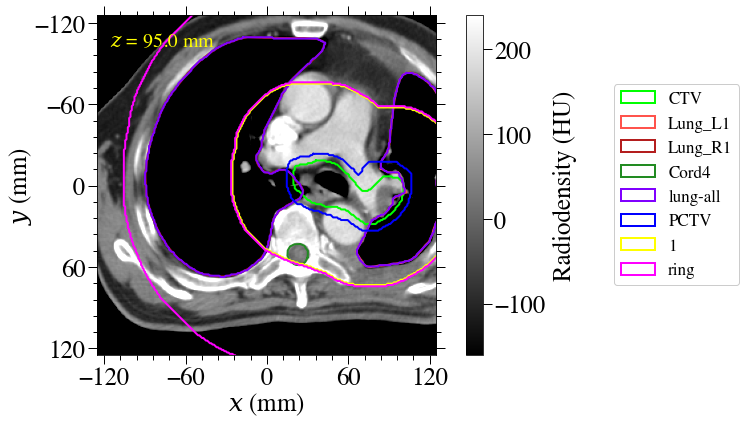

In [6]:
# Plot image with structure set overlain, and with off-image legend.

# Overlay default annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"color": 'yellow', "fontsize": annotation_fontsize}

# Plot image:
# sl=70 : plot slice 70;
# title="" : omit title;
# rois=ss : overlay structure set;
# colorbar=1 : show colour bar for image.
# legend=True : show legend identifying ROIs of structure set.
# legend_loc="center left" : Use centre left of legend as reference point for fixing its location.
# legend_bbox_to_anchor=(1.5, 0.5) : Coordinates of legend reference point, in system where image axes extend from 0 to 1.

im.view(init_sl=70, title="", rois=ss, colorbar=1,
        legend=True, legend_loc="center left", legend_bbox_to_anchor=(1.5, 0.5), **kwargs);

## Plotting image with two colour bars

The following demonstrates plotting of an image, with structure set and dose overlain, with colour bars for image and dose.

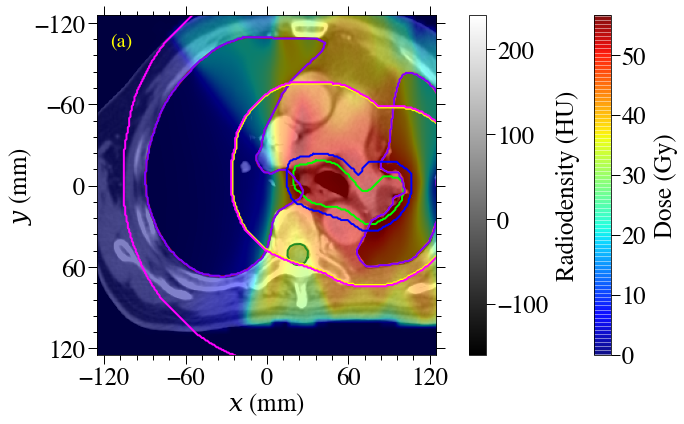

In [7]:
# Plot image with dose and structure set overlain, and with colour bars.

# Overlay user-defined annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"text": "(a)", "color": 'yellow', "fontsize": annotation_fontsize}

# Plot image:
# sl=60 : plot slice 60;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=ss : overlay structure set;
# colorbar=2 : show colour bars for image and overlay.
im.view(init_sl=60, title="", dose=dose, rois=ss, colorbar=2, **kwargs);

## Plotting without axis annotations

The following demonstrates plotting an image, with structure set and dose overlain, without axis annotations and colour bars.

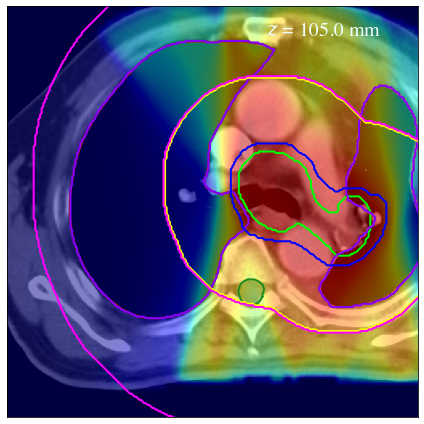

In [8]:
# Plot image without axis annotations.
# In contrast with plotting for no_axis_labels=True, the axes themselves are shown.

# Set tick marks to have zero size.
plt.rc(("xtick.major", "ytick.major"), size=0)
plt.rc(("xtick.minor", "ytick.minor"), size=0)

# Suppress axis and tick labels.
kwargs["no_xlabel"] = True
kwargs["no_xtick_labels"] = True
kwargs["no_ylabel"] = True
kwargs["no_ytick_labels"] = True

# Overlay default slice information, in azure, at user-defined position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {'text': None, 'color': 'azure', 'xy': (0.63, 0.93),
                            "fontsize": annotation_fontsize}

# Plot image:
# pos=-15 : plot slice at z=-15 mm;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=ss : overlay structure set;
im.view(init_pos=105, title="", dose=dose, rois=ss, **kwargs);

## Plotting subset of structure-set ROIs

The following demonstrates plotting an image, with a subset of structure-set ROIs, and dose overlain, with colour bars for image and dose.  A legend identifies the ROIs displayed.

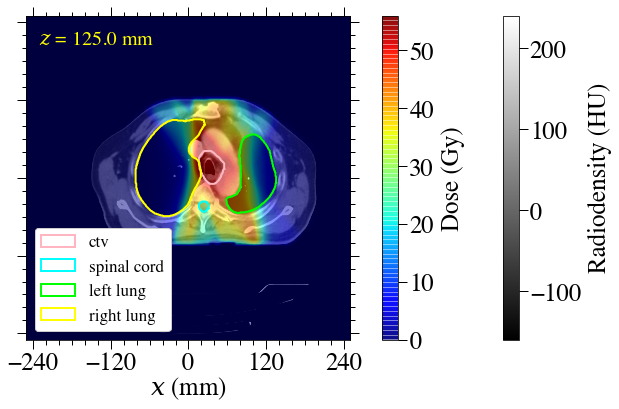

In [9]:
# Filter rois:
rois = ss.filtered_copy({"ctv": "ctv", "spinal cord": "cord*", "left lung" : "lung_l1", "right lung": "lung_r1"}, keep_renamed_only=True)
roi_colours = {"ctv": "lightpink", "spinal cord": "cyan", "left lung": "lime", "right lung": "yellow"}
for roi in rois:    
    roi.set_color(roi_colours[roi.name])

# For major and minor ticks, set size and width.
plt.rc(("xtick.major", "ytick.major"), size=9, width=1.0)
plt.rc(("xtick.minor", "ytick.minor"), size=4.5, width=1.0)
    
# Set default font size - small enough that legend doesn't obscure image.
plt.rc("font", size=17)
    
# Suppress axis and tick labels for y axis.
kwargs["no_xlabel"] = False
kwargs["no_xtick_labels"] = False
kwargs["no_ylabel"] = True
kwargs["no_ytick_labels"] = True

# Show major ticks at specified interval (axis units).
kwargs["major_ticks"] = 120
# Show minor ticks at specified interval (axis units).
kwargs["minor_ticks"] = 6

# Specify zoom factor.
kwargs["zoom"] = 1.0

# Overlay default annotation, in black, at default position.
# For list of named colours, see:
#     https://matplotlib.org/stable/gallery/color/named_colors.html
kwargs["annotate_slice"] = {"color": 'yellow', "fontsize": annotation_fontsize}

# Plot dose:
# pos=18 : plot slice at z=18;
# title="" : omit title;
# include_image=True : underlay associated image;
# rois=rois : overlay filtered structure set;
# colorbar=2 : show colour bars for dose and underlay.
#     => Note that when plotting a dose with image underlay the order of the colour bars is reversed
#        with resect to plotting an image with dose overlay.
# legend=True : show legend identifying ROIs of structure set.
dose.view(init_pos=125, title="", include_image=True, rois=rois, colorbar=2, legend=True, **kwargs);

## Plotting non-interactive image (z-y view)

The following demonstrates plotting a non-interactive image, showing z-y view for a selected image column, with a subset of structure-set ROIs and dose overlain.

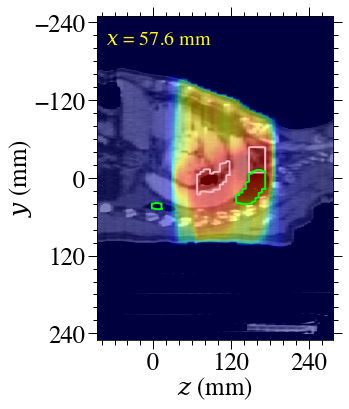

In [10]:
# Include axis and tick labels for both axes.
kwargs["no_xlabel"] = False
kwargs["no_xtick_labels"] = False
kwargs["no_ylabel"] = False
kwargs["no_ytick_labels"] = False

# Make this plot non-interactive.
kwargs["no_ui"] = True

# Plot image in z-y plane:
# pos=9.1 : plot slice at x=57.6;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=rois : overlay filtered structure set;
# colorbar=0 : omit colour bars.
im.view(init_view="z-y", init_pos=57.6, title="", dose=dose, rois=rois, colorbar=0, **kwargs)
kwargs["no_ui"] = False

## Plotting non-interactive image (z-x view)

The following demonstrates plotting a non-interactive image, showing z-x view for a selected image row, with a subset of structure-set ROIs and dose overlain.

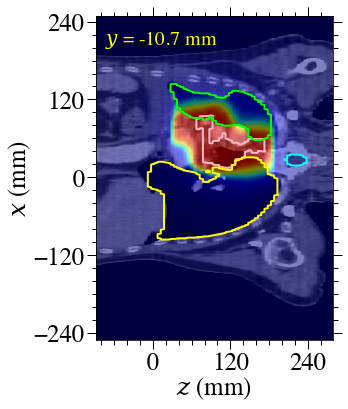

In [11]:
# Make this plot non-interactive.
kwargs["no_ui"] = True

# Plot image in z-x plane:
# pos=9.1 : plot slice at y=-10.7;
# title="" : omit title;
# dose=dose : olverlay dose;
# rois=rois : overlay filtered structure set;
# colorbar=0 : omit colour bars.
im.view(init_view="z-x", init_pos=-10.7, title="", dose=dose, rois=rois, colorbar=0, **kwargs)
kwargs["no_ui"] = False

## Plotting dose-volume histograms

The following demonstrates plotting dose-volume histograms for previously selected subset of structure-set ROIs.

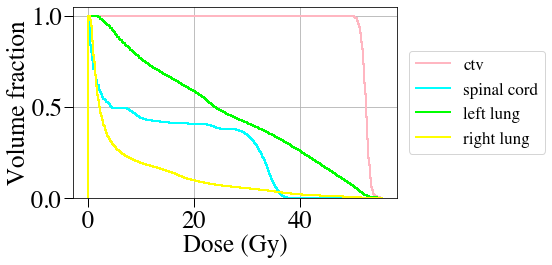

In [12]:
# Plot dose-volume histograms for ROIs.
dose.plot_dvh(rois=rois, bins=500);